In [1]:
%cd ../..
%pwd
import json
import pathlib
from collections import Counter, defaultdict
import matplotlib.pyplot as plt
import torch
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
import joblib      # to save the best probe

# Point these at *your* directories ------------------------------------------------
COMPLETIONS_DIR = pathlib.Path("~/CoTFaithChecker/e_confirm_xy_yx/outputs/matched_vals_gt").expanduser()
HIDDEN_DIR      = pathlib.Path("~/CoTFaithChecker/h_hidden_space/outputs/f1_hint_xyyx/xyyx_deterministic/gt_lt_completions_1").expanduser()


/usr/local/lib/python3.10/dist-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


/root/CoTFaithChecker


In [2]:
# ─── Collect first-slot answers, skipping nulls ────────────────────────────────
tally = Counter()
files = COMPLETIONS_DIR.glob("*.json")

for fp in files:
    with fp.open() as f:
        data = json.load(f)
        for row in data:
            # a_answers ---------------------------------------------------------
            a0 = row["a_answers"][0]
            if a0 in ("YES", "NO"):              # ignore None
                tally[f"a_{a0}"] += 1

            # b_answers ---------------------------------------------------------
            b0 = row["b_answers"][0]
            if b0 in ("YES", "NO"):
                tally[f"b_{b0}"] += 1

            # same --------------------------------------------------------------
            same0 = row["same"][0]
            if same0 in (True, False):
                tally[f"same_{same0}"] += 1

print("Raw counts (nulls skipped):", tally)


Raw counts (nulls skipped): Counter({'a_YES': 688, 'b_YES': 640, 'same_False': 545, 'same_True': 482, 'b_NO': 387, 'a_NO': 376})


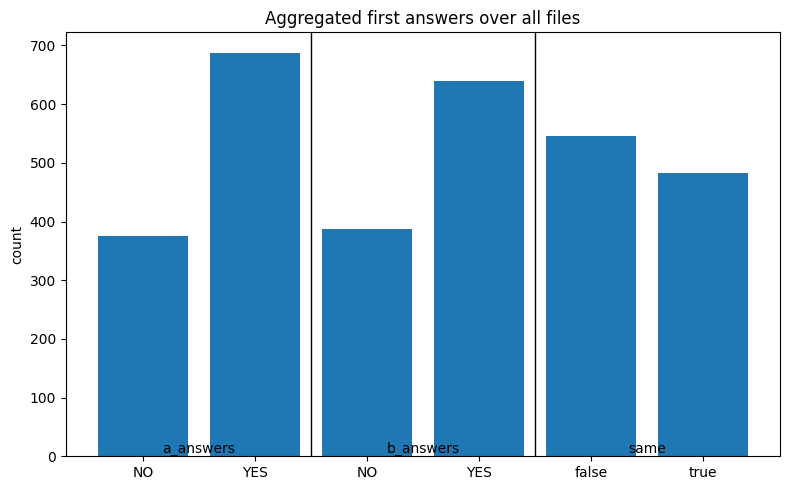

In [3]:
# ─── Build the ordered bar-plot ────────────────────────────────────────────────
groups = [("a_NO",  "a_YES"),          # left-hand group
          ("b_NO",  "b_YES"),          # middle group
          ("same_False", "same_True")] # right-hand group

bar_labels  = sum(groups, ())                      # ("a_NO","a_YES", ... )
bar_heights = [tally[k] for k in bar_labels]       # 6 heights in order

fig, ax = plt.subplots(figsize=(8,5))
x = np.arange(len(bar_labels))
ax.bar(x, bar_heights)

# cosmetics ---------------------------------------------------------------
ax.set_xticks(x)
ax.set_xticklabels(["NO","YES","NO","YES","false","true"])
for pos in (1.5, 3.5):           # vertical separators between groups
    ax.axvline(pos, color='k', linewidth=1)

ax.text(0.5, 0,  "a_answers",  ha='center', va='bottom', transform=ax.get_xaxis_transform())
ax.text(2.5, 0,  "b_answers",  ha='center', va='bottom', transform=ax.get_xaxis_transform())
ax.text(4.5, 0,  "same",       ha='center', va='bottom', transform=ax.get_xaxis_transform())

ax.set_ylabel("count")
ax.set_title("Aggregated first answers over all files")
plt.tight_layout()


In [4]:
# ── paths ──────────────────────────────────────────────────────────────────────
COMPLETIONS_DIR = pathlib.Path(
    "~/CoTFaithChecker/e_confirm_xy_yx/outputs/matched_vals_gt"
).expanduser()
HIDDEN_DIR = pathlib.Path(
    "~/CoTFaithChecker/h_hidden_space/outputs/f1_hint_xyyx/xyyx_deterministic/gt_lt_completions_1"
).expanduser()

# ── 1.  Build a lookup:  (dataset_key, question_id) → FIRST answer ("YES"/"NO") ─
answer_lookup = {}
for fp in COMPLETIONS_DIR.glob("*.json"):
    dataset_key = "_".join(fp.stem.split("_")[:2])          # e.g.  wm-book-length_gt
    with fp.open() as f:
        for obj in json.load(f):
            ans = obj["a_answers"][0]
            if ans in ("YES", "NO"):                       # drop nulls
                answer_lookup[(dataset_key, obj["question_id"])] = ans

print(f"Loaded {len(answer_lookup):,} answer entries")

# ── 2.  Walk every *.pt, build X & y for every layer ───────────────────────────
X_by_layer, y_by_layer = defaultdict(list), defaultdict(list)
example_counts = Counter()

for pt in HIDDEN_DIR.glob("*.pt"):
    parts = pt.stem.split("_")
    dataset_key = "_".join(parts[:2])      # wm-book-length_gt  OR  wm-book-length_lt
    expected    = parts[2]                 # YES / NO
    try:
        qid = int(parts[3])
    except ValueError:
        continue                           # unexpected naming → skip

    given = answer_lookup.get((dataset_key, qid))
    if given not in ("YES", "NO"):
        continue                           # no matching answer → skip

    label = int(given == expected)         # 1 = behaved, 0 = mismatch
    example_counts["behaved"      if label else "always_same"] += 1

    # load activations
    hstates = torch.load(pt, map_location="cpu")["hidden_states"]
    for layer_idx, h in enumerate(hstates):
        X_by_layer[layer_idx].append(h.mean(0).numpy())     # (dim,)
        y_by_layer[layer_idx].append(label)

print("Example class counts:", example_counts)

# ── 3.  Sweep layers with a logistic‐regression probe ──────────────────────────
scores, best_layer, best_score, best_clf = {}, None, -np.inf, None

for layer, Xlist in X_by_layer.items():
    y = np.array(y_by_layer[layer])
    if len(np.unique(y)) < 2:                 # need both classes
        continue

    X = np.vstack(Xlist)
    clf = make_pipeline(StandardScaler(), LogisticRegression(max_iter=1000, class_weight="balanced"))
    acc = cross_val_score(clf, X, y, cv=5, scoring="accuracy").mean()
    scores[layer] = acc

    if acc > best_score:
        best_layer, best_score, best_clf = layer, acc, clf

if best_layer is None:
    raise RuntimeError("No layer had ≥2 classes. Check the directory paths or filenames.")

print("\nLayer  →  5-fold CV accuracy")
for layer, acc in sorted(scores.items()):
    print(f"{layer:>3} : {acc:.3f}")
print(f"\nBest = layer {best_layer}  (accuracy {best_score:.3f})")

# ── 4.  Fit on all data from the best layer & save probe ───────────────────────
X_all = np.vstack(X_by_layer[best_layer])
y_all = np.array(y_by_layer[best_layer])
best_clf.fit(X_all, y_all)

PROBE_PATH = pathlib.Path("linear_probe_best_layer.pt")
joblib.dump({"layer": best_layer, "pipeline": best_clf}, PROBE_PATH)
print(f"Probe saved ➜  {PROBE_PATH.resolve()}")


Loaded 1,064 answer entries


/tmp/ipykernel_24944/2437615969.py:42: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  hstates = torch.load(pt, map_location="cpu")["hidden_states"]


TypeError: list indices must be integers or slices, not str

In [7]:
# ── 2.  Walk every *.pt activation file and build X, y ─────────────────────────
X_by_layer, y_by_layer = defaultdict(list), defaultdict(list)
example_counts = Counter()

for pt in HIDDEN_DIR.glob("*.pt"):
    parts       = pt.stem.split("_")
    dataset_key = "_".join(parts[:2])          # wm-book-length_gt  /  wm-book-length_lt
    expected    = parts[2]                     # YES / NO
    try:
        qid = int(parts[3])                    # the “…_1_…”
    except ValueError:
        continue                               # unexpected file name → skip

    given = answer_lookup.get((dataset_key, qid))
    if given not in ("YES", "NO"):
        continue                               # no matching answer → skip

    label = int(given == expected)             # 1 = behaved, 0 = always-same
    example_counts["behaved" if label else "always_same"] += 1

    # ── load activations, tolerate both formats ───────────────────────────────
    raw = torch.load(pt, map_location="cpu")

    if isinstance(raw, dict):                  # expected key names vary across dumps
        for k in ("hidden_states", "states", "activations"):
            if k in raw:
                hstates = raw[k]
                break
        else:
            raise KeyError(f"No hidden states in {pt.name}")
    elif isinstance(raw, (list, tuple)):
        hstates = raw
    else:
        raise TypeError(f"Unrecognised activation type in {pt.name}: {type(raw)}")

    # ── convert each layer tensor → 1D feature vector ─────────────────────────
    for layer_idx, h in enumerate(hstates):
        if h.ndim == 3:                # (batch, seq, dim)  – average over batch & seq
            feat = h.mean(dim=(0, 1)).numpy()
        elif h.ndim == 2:              # (seq, dim)         – average over seq
            feat = h.mean(dim=0).numpy()
        else:
            raise ValueError(f"Tensor shape {tuple(h.shape)} not handled")

        X_by_layer[layer_idx].append(feat)
        y_by_layer[layer_idx].append(label)

print("Example class counts:", example_counts)


/tmp/ipykernel_24944/2546815273.py:22: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  raw = torch.load(pt, map_location="cpu")


Example class counts: Counter({'behaved': 44, 'always_same': 44})


In [9]:
# ─── Retrain on *all* data from that layer & save the probe to disk ────────────
X_best = np.vstack(X_by_layer[best_layer])
y_best = np.array(y_by_layer[best_layer])

best_clf.fit(X_best, y_best)
PROBE_PATH = pathlib.Path("linear_probe_best_layer.pt")
joblib.dump(dict(layer=best_layer, sklearn_pipeline=best_clf), PROBE_PATH)

print(f"Saved probe for layer {best_layer} to {PROBE_PATH.resolve()}")


ValueError: need at least one array to concatenate